In [1]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture2 as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-28 19:47:44.725748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 19:47:44.889886: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 19:47:44.894338: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 19:47:44.894356: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 3e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                   "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
Electrons_features = ["AnalysisElectrons_pt_NOSYS","AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", 
                    "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]
Muon_Features = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi","AnalysisMuons_z0sinTheta", 
                    "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + Electrons_features + Muon_Features + reconstructed_jet_features, entry_stop=MAXEVENTS)

In [7]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [8]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [ ]:
# Select tracks from the events
tracks = events[track_features]
electrons = events[Electrons_features]
muons = events[Muon_Features]
rejets = events[reconstructed_jet_features]

# Match the tracks to the jets
mask_rejets = DSNNA.Match_Reconstructed(jets, rejets)
mask_tracks = DSNNA.Match_Tracks(jets, tracks)
mask_electrons = DSNNA.Match_Electrons(jets,electrons)
mask_muons = DSNNA.Match_Muons(jets,muons)
matchedtracks = tracks[mask_tracks]
matchedelectrons = electrons[mask_electrons]
matchedmuons = muons[mask_muons]

# Pad and Flatten the data
rejets = rejets[mask_rejets]
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)
matchedelectrons = DSNNA.flatten(matchedelectrons, MAXTRACKS)
matchedmuons = DSNNA.flatten(matchedmuons, MAXTRACKS)

In [ ]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
rejets = rejets[bjets]
rejets = DSNNA.pad(rejets,MAXTRACKS)[:,0]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

rejets_pt = rejets["AnalysisJets_pt_NOSYS"].to_numpy()
rejets_eta = rejets["AnalysisJets_eta"].to_numpy()
rejets_phi = rejets["AnalysisJets_phi"].to_numpy()
rejets_m = rejets["AnalysisJets_m"].to_numpy()
re_b_jets = np.stack([rejets_pt,rejets_eta,rejets_phi, rejets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
print("There are {} tracks inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} electrons inputs".format(np.shape(matchedelectrons)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} muons inputs".format(np.shape(matchedmuons)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 tracks inputs
There are 32 electrons inputs
There are 32 muons inputs


In [ ]:
# Transform the jet and tracks to unstructed data.
rejets = rejets.to_numpy()
rejets = structured_to_unstructured(rejets[reconstructed_jet_features])
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)
matchedelectrons  = structured_to_unstructured(matchedelectrons)
matchedmuons = structured_to_unstructured(matchedmuons)

In [ ]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
polarelectrons = matchedelectrons.to_numpy()
polarmuons = matchedmuons.to_numpy()

Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

electrons_pt = polarelectrons[:,:,0].reshape(-1,Num_events,1)
electrons_eta = polarelectrons[:,:,1].reshape(-1,Num_events,1)
electrons_phi = polarelectrons[:,:,2].reshape(-1,Num_events,1)

electrons_pep = np.concatenate([electrons_pt,electrons_eta,electrons_phi], axis = -1) 
print(electrons_pep.shape)

muons_pt = polarmuons[:,:,0].reshape(-1,Num_events,1)
muons_eta = polarmuons[:,:,1].reshape(-1,Num_events,1)
muons_phi = polarmuons[:,:,2].reshape(-1,Num_events,1)

muons_pep = np.concatenate([muons_pt,muons_eta,muons_phi], axis = -1) 
print(muons_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

rejets_pt = re_b_jets[:,0].reshape(-1,1)
rejets_eta = re_b_jets[:,1].reshape(-1,1)
rejets_phi = re_b_jets[:,2].reshape(-1,1)

re_b_jets_pep = np.concatenate([rejets_pt,rejets_eta,rejets_phi], axis = -1) 
print(re_b_jets_pep.shape)

reconjet_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(re_b_jets)
re_b_jets_m = re_b_jets[:,-1].reshape(-1,1)
re_b_jets = np.concatenate([reconjet_p,re_b_jets_pep,re_b_jets_m], axis = -1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
electrons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedelectrons.to_numpy())
muons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedmuons.to_numpy())

bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
electrons = np.concatenate([electrons_p, electrons_pep, matchedelectrons[:,:,3:].to_numpy()], axis = 2)
muons = np.concatenate([muons_p, muons_pep, matchedmuons[:,:,3:].to_numpy()], axis = 2)

print(np.shape(tracks), np.shape(electrons), np.shape(muons))
particles = np.concatenate([tracks,electrons,muons], axis = 1)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 32, 3)
(96659, 32, 3)
(96659, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


(96659, 32, 11) (96659, 32, 11) (96659, 32, 11)


In [29]:
np.shape(particles)
#Mask out the MASKVALs used to pad the arrays
particles = np.ma.masked_values(particles,-999)
#Mask out the MASKVALs used to pad the reconstructed jets
re_b_jets = np.ma.masked_values(re_b_jets,-999)
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [30]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)
#Creates an approximate track momentum and 4 momentum for the network to use.
particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)
particles_4_Momentum = np.stack([particles_Momentum, particles[:,:,0], particles[:,:,1], particles[:,:,2]], axis = -1)
print(particles_4_Momentum.shape)
#Creates a very approximate track mass for the network to use.
particles_Invariant_Mass = np.sqrt((np.sum(particles_4_Momentum, axis = 1) * np.sum(particles_4_Momentum, axis = 1)).sum(axis = -1))
print(particles_Invariant_Mass.shape)

(96659, 3)


/tmp/ipykernel_12087/1752972381.py:9: RuntimeWarning: invalid value encountered in sqrt
  particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)


(96659, 96, 4)
(96659,)


In [31]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
re_b_jets_mag = np.linalg.norm(re_b_jets[:,:3], axis = 1)
particles_Momentum = np.sum(np.linalg.norm(particles[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

ConeRadius = np.sqrt(re_b_jets_pep[:,1]**2 + re_b_jets_pep[:,2]**2)
LogConeRadius = np.log(ConeRadius)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets_m[:,0]**2))
re_b_jets_energy_pt.shape

re_b_jets_energy = np.sqrt((re_b_jets_m[:,0]**2) + (re_b_jets_mag**2))
print(re_b_jets_energy.shape)

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)

re_b_jet_energy_mass_ratio = re_b_jets_energy/re_b_jets_m[:,0]
re_b_jet_energy_mass_ratio[np.isinf(re_b_jet_energy_mass_ratio)] = np.median(re_b_jet_energy_mass_ratio)

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_particles = np.sum(particles[:,:,0], axis = 1)
sum_py_particles = np.sum(particles[:,:,1], axis = 1)
sum_pz_particles = np.sum(particles[:,:,2], axis = 1)
sum_pt_particles = np.sum(particles[:,:,3], axis = 1)
print(sum_pt_particles.shape)

sum_eta_particles = np.sum(particles[:,:,4], axis = 1)
sum_phi_particles = np.sum(particles[:,:,5], axis = 1)
sum_z0sin_particles = np.sum(particles[:,:,6], axis = 1)
sum_d0sig_particles = np.sum(particles[:,:,7], axis = 1)

sum_d0_particles = np.sum(particles[:,:,8], axis = 1)
sum_d0sigPV_particles = np.sum(particles[:,:,9], axis = 1)
sum_d0PV_particles = np.sum(particles[:,:,10], axis = 1)

sum_px_particles_RSE = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1))
sum_py_particles_RSE= np.sqrt(np.sum(particles[:,:,1]**2, axis = 1))
sum_pz_particles_RSE = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1))
sum_pt_particles_RSE = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1))
print(sum_pt_particles_RSE.shape)

sum_px_particles_RSEC = np.power(np.sum(particles[:,:,0]**3, axis = 1), 1/3)
sum_py_particles_RSEC= np.power(np.sum(particles[:,:,1]**3, axis = 1), 1/3)
sum_pz_particles_RSEC = np.power(np.sum(particles[:,:,2]**3, axis = 1), 1/3)
sum_pt_particles_RSEC = np.power(np.sum(particles[:,:,3]**3, axis = 1), 1/3)
print(sum_pt_particles_RSEC.shape)

sum_px_particles_RSEC[np.isnan(sum_px_particles_RSEC)] = np.median(sum_px_particles_RSEC)
sum_py_particles_RSEC[np.isnan(sum_py_particles_RSEC)] = np.median(sum_py_particles_RSEC)
sum_pz_particles_RSEC[np.isnan(sum_pz_particles_RSEC)] = np.median(sum_pz_particles_RSEC)
sum_pt_particles_RSEC[np.isnan(sum_pt_particles_RSEC)] = np.median(sum_pt_particles_RSEC)

sum_eta_particles_RSE = np.sqrt(np.sum(particles[:,:,4]**2, axis = 1))
sum_phi_particles_RSE= np.sqrt(np.sum(particles[:,:,5]**2, axis = 1))
sum_z0sin_particles_RSE = np.sqrt(np.sum(particles[:,:,6]**2, axis = 1))
sum_d0sig_particles_RSE = np.sqrt(np.sum(particles[:,:,7]**2, axis = 1))

sum_d0_particles_RSE= np.sqrt(np.sum(particles[:,:,8]**2, axis = 1))
sum_d0sigPV_particles_RSE = np.sqrt(np.sum(particles[:,:,9]**2, axis = 1))
sum_d0PV_particles_RSE = np.sqrt(np.sum(particles[:,:,10]**2, axis = 1))

RSM_scaled_px = sum_px_particles_RSE/sum_px_particles
RSM_scaled_py = sum_py_particles_RSE/sum_py_particles
RSM_scaled_pz = sum_pz_particles_RSE/sum_pz_particles
RSM_scaled_pt = sum_pt_particles_RSE/sum_pt_particles
print(RSM_scaled_pt.shape)

RSMC_scaled_px = sum_px_particles_RSEC/sum_px_particles
RSMC_scaled_py = sum_py_particles_RSEC/sum_py_particles
RSMC_scaled_pz = sum_pz_particles_RSEC/sum_pz_particles
RSMC_scaled_pt = sum_pt_particles_RSEC/sum_pt_particles
print(RSMC_scaled_pt.shape)

RSM_scaled_eta = sum_eta_particles_RSE/sum_eta_particles
RSM_scaled_phi = sum_phi_particles_RSE/sum_phi_particles
RSM_scaled_z0sin = sum_z0sin_particles_RSE/sum_z0sin_particles
RSM_scaled_d0sig = sum_pt_particles_RSE/sum_d0sig_particles

RSM_scaled_d0 = sum_d0_particles_RSE/sum_d0_particles
RSM_scaled_d0sigPV = sum_d0sigPV_particles_RSE/sum_d0sigPV_particles
RSM_scaled_d0PV = sum_d0PV_particles_RSE/sum_d0PV_particles

RMS_scaled_px = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(particles[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_particles = np.log(abs(particles[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_particles = np.log(abs(particles[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_particles = np.log(abs(particles[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_particles = np.log(abs(particles[:,:,3]/b_jets[:,np.newaxis,3]))
Log_particles = np.stack([Log_px_particles, Log_py_particles, Log_pz_particles, Log_pt_particles], axis = -1)

Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])
Log_Momenta = np.log(abs(particles_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

particles_fractions_px = particles[:,:,0]/b_jets[:,np.newaxis,0]
particles_fractions_py = particles[:,:,1]/b_jets[:,np.newaxis,1]
particles_fractions_pz = particles[:,:,2]/b_jets[:,np.newaxis,2]
particles_fractions_pt = particles[:,:,3]/b_jets[:,np.newaxis,3]
print(particles_fractions_pt.shape)
particles_fractions = np.stack([particles_fractions_px,particles_fractions_py, particles_fractions_pz], axis = -1)
print(particles_fractions.shape)

print(particles_fractions.shape)
print(particles[0,0,0]/b_jets[0,0])
print(np.mean(particles_fractions),np.std(particles_fractions))

particles_projection = ((particles[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(particles_projection.shape)
particles_Momenta = np.stack([sum_px_particles, sum_py_particles, sum_pz_particles], axis = -1)
print(particles_Momenta.shape)
Sum_particles_projection = ((particles_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_particles_projection.shape)

b_jet_energy_ratio_px = sum_px_particles/b_jets_energy
b_jet_energy_ratio_py = sum_py_particles/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_particles/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_particles/b_jets_energy

re_b_jet_energy_ratio_px = sum_px_particles/re_b_jets_energy
re_b_jet_energy_ratio_py = sum_py_particles/re_b_jets_energy
re_b_jet_energy_ratio_pz = sum_pz_particles/re_b_jets_energy
re_b_jet_energy_ratio_pt = sum_pt_particles/re_b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy

re_b_jet_energy_ratio_cart = re_b_jets_mag/re_b_jets_energy
re_b_jet_energy_ratio_pt = re_b_jets[:,4]/re_b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)

re_b_jet_energy_ratio_total = np.sum(re_b_jets[:,4])/np.sum(re_b_jets_energy)  
re_b_jet_transverse_mass = np.sqrt(re_b_jets_energy**2 - re_b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)

print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))
re_b_jets_extended = np.stack([re_b_jets[:,0], re_b_jets[:,1], re_b_jets[:,2],re_b_jets[:,3],re_b_jets[:,4], re_b_jets[:,5], re_b_jets[:,6], 
                   re_b_jets_mag, sum_px_particles, sum_py_particles, sum_pz_particles, sum_pt_particles, sum_eta_particles,
                   sum_phi_particles, sum_z0sin_particles, sum_d0sig_particles, sum_d0_particles, sum_d0sigPV_particles, sum_d0PV_particles,
                   sum_px_particles_RSE, sum_py_particles_RSE, sum_pz_particles_RSE, sum_pt_particles_RSE, sum_eta_particles_RSE, sum_phi_particles_RSE,
                   sum_z0sin_particles_RSE, sum_d0sig_particles_RSE, sum_d0_particles_RSE, sum_d0sigPV_particles_RSE, sum_d0PV_particles_RSE,
                   RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RSM_scaled_eta, RSM_scaled_phi, RSM_scaled_z0sin, RSM_scaled_d0sig, RSM_scaled_d0sigPV, RSM_scaled_d0PV,
                   RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, RSM_scaled_d0sig,re_b_jet_transverse_mass, 
                   Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, re_b_jets_energy, re_b_jet_energy_ratio_px, 
                   re_b_jet_energy_ratio_py, re_b_jet_energy_ratio_pz, re_b_jet_energy_ratio_cart, re_b_jet_energy_ratio_pt, 
                   re_b_jet_energy_mass_ratio, ConeRadius, LogConeRadius, np.full((len(re_b_jets),),re_b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6,bhads_pt/1e6, bhads_eta, bhads_phi, bhads_energy/1e6, bhads_fractions_pt, bhads_projection,
                        b_jets[:,0]/1e6, b_jets[:,1]/1e6, b_jets[:,2]/1e6, b_jets[:,3]/1e6, b_jets[:,4], b_jets[:,5],b_jets[:,6]/1e6, b_jets_energy/1e6], axis = -1)

(96659,)
(96659,) (96659, 1)
(96659,)
(96659,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-4195.466731248074 618.1237235802715
Hello


/tmp/ipykernel_12087/1294475033.py:30: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(96659,)
(96659,)


/tmp/ipykernel_12087/1294475033.py:72: RuntimeWarning: invalid value encountered in power
  sum_px_particles_RSEC = np.power(np.sum(particles[:,:,0]**3, axis = 1), 1/3)
/tmp/ipykernel_12087/1294475033.py:73: RuntimeWarning: invalid value encountered in power
  sum_py_particles_RSEC= np.power(np.sum(particles[:,:,1]**3, axis = 1), 1/3)
/tmp/ipykernel_12087/1294475033.py:74: RuntimeWarning: invalid value encountered in power
  sum_pz_particles_RSEC = np.power(np.sum(particles[:,:,2]**3, axis = 1), 1/3)


(96659,)
(96659,)
(96659,)
(96659,)


/tmp/ipykernel_12087/1294475033.py:125: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_12087/1294475033.py:125: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_12087/1294475033.py:126: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_12087/1294475033.py:126: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_12087/1294475033.py:127: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_12087/1294475033.py:127: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_12087/1294475033.py:128: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])


(96659,)
(96659, 96)
(96659, 96, 3)
(96659, 96, 3)
0.14894195156291137
-889.5405690026124 312.0555330470199
(96659, 96)
(96659, 3)
(96659,)
(96659,)
(96659,)
79564.74
()
(96659,)
(96659,)
215380.48 189104.06


In [112]:
#Lays out the jet autoencoder network. Creates a lower dimensional representation of the jets features
def JetEncoder(Num_Jets_Features, bottleneck, MASKVAL = -999):

    Jet_features = keras.layers.Input(shape = [Num_Jets_Features])

    Jet_layers = keras.layers.Masking(MASKVAL)(Jet_features)

    #Encoder:
    Jet_layers_Embedding = keras.layers.Dense(Num_Jets_Features*8, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers)
    Jet_layers_Embedding = keras.layers.Dense(Num_Jets_Features*4, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(Num_Jets_Features*2, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(round(Num_Jets_Features), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Embedding = keras.layers.BatchNormalization()(Jet_layers_Embedding)
    
    #Decoder:
    Jet_layers_Reconstructed = keras.layers.Dense(bottleneck, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Embedding)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(round(Num_Jets_Features), activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.BatchNormalization()(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(Num_Jets_Features*2, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(Num_Jets_Features*4, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)
    Jet_layers_Reconstructed = keras.layers.Dense(Num_Jets_Features*8, activation = "gelu", kernel_initializer = "he_normal")(Jet_layers_Reconstructed)

    #Output
    output = keras.layers.Dense(Num_Jets_Features, activation = "linear")(Jet_layers_Reconstructed)

    Model = keras.Model(inputs = Jet_features, outputs = output)

    return Model

In [113]:
scaled_reconstructed_jets = np.stack([re_b_jets[:,0]/1e6, re_b_jets[:,1]/1e6, re_b_jets[:,2]/1e8, re_b_jets[:,3]/1e6,re_b_jets[:,4], re_b_jets[:,5], re_b_jets[:,6]/1e6, re_b_jets_energy/1e8, re_b_jet_transverse_mass/1e5], axis = -1)
scaled_true_jets = np.stack([b_jets[:,0]/1e6, b_jets[:,1]/1e6, b_jets[:,2]/1e8, b_jets[:,3]/1e6, b_jets[:,4], b_jets[:,5], b_jets[:,6]/1e6, b_jets_energy/1e8, b_jet_transverse_mass/1e5], axis = -1)

In [101]:
np.max(scaled_true_jets)

12.095278

In [114]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/DeepNetWeights&Biases.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [115]:
#Initialises the b_jet autoencoder
BParticleEncoder = JetEncoder(np.shape(scaled_reconstructed_jets)[1], 5)
#Attach the loss and optimizer to the encoder
BParticleEncoder.compile(
    loss = keras.losses.huber,
    optimizer = keras.optimizers.Nadam(LR),
)
print(BParticleEncoder.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 9)]               0         
                                                                 
 masking_8 (Masking)         (None, 9)                 0         
                                                                 
 dense_47 (Dense)            (None, 18)                180       
                                                                 
 batch_normalization_31 (Bat  (None, 18)               72        
 chNormalization)                                                
                                                                 
 dense_48 (Dense)            (None, 9)                 171       
                                                                 
 batch_normalization_32 (Bat  (None, 9)                36        
 chNormalization)                                          

In [116]:
#Trains the b_jet autoencoder for the jet features
history_1 = BParticleEncoder.fit(
    scaled_reconstructed_jets, scaled_true_jets,
    validation_split= 0.3,
    epochs= 1000,
    batch_size= BATCHSIZE,
     callbacks = [early_stopping, reduce_learn_on_plateau],
    )

Epoch 1/1000
1058/1058 [==============================] - 6s 3ms/step - loss: 0.1185 - val_loss: 0.0646 - lr: 3.0000e-04
Epoch 2/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0648 - val_loss: 0.0508 - lr: 3.0000e-04
Epoch 3/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0567 - val_loss: 0.0466 - lr: 3.0000e-04
Epoch 4/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0533 - val_loss: 0.0447 - lr: 3.0000e-04
Epoch 5/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0516 - val_loss: 0.0440 - lr: 3.0000e-04
Epoch 6/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0503 - val_loss: 0.0434 - lr: 3.0000e-04
Epoch 7/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0499 - val_loss: 0.0432 - lr: 3.0000e-04
Epoch 8/1000
1058/1058 [==============================] - 3s 3ms/step - loss: 0.0492 - val_loss: 0.0429 - lr: 3.0000e-04
Epoch 9/1000
1058/1058 [========

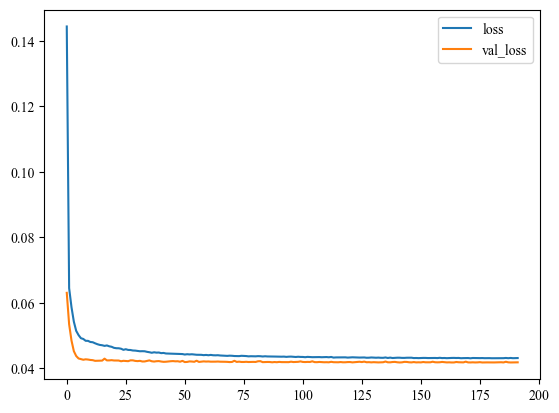

In [106]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history_1.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/historyResidualNeuralNetwork.csv')

In [94]:
#Evaluate the entire performance of the model
loss = BParticleEncoder.evaluate(scaled_reconstructed_jets,scaled_true_jets,verbose = 2)
print("The TrackParticleEncoder has loss: ", loss)

3021/3021 - 2s - loss: 0.0418 - 2s/epoch - 738us/step
The TrackParticleEncoder has loss:  0.04176688566803932


In [108]:
predictions = BParticleEncoder.predict(scaled_reconstructed_jets)

3021/3021 [==============================] - 3s 850us/step


In [109]:
Error = predictions - scaled_reconstructed_jets

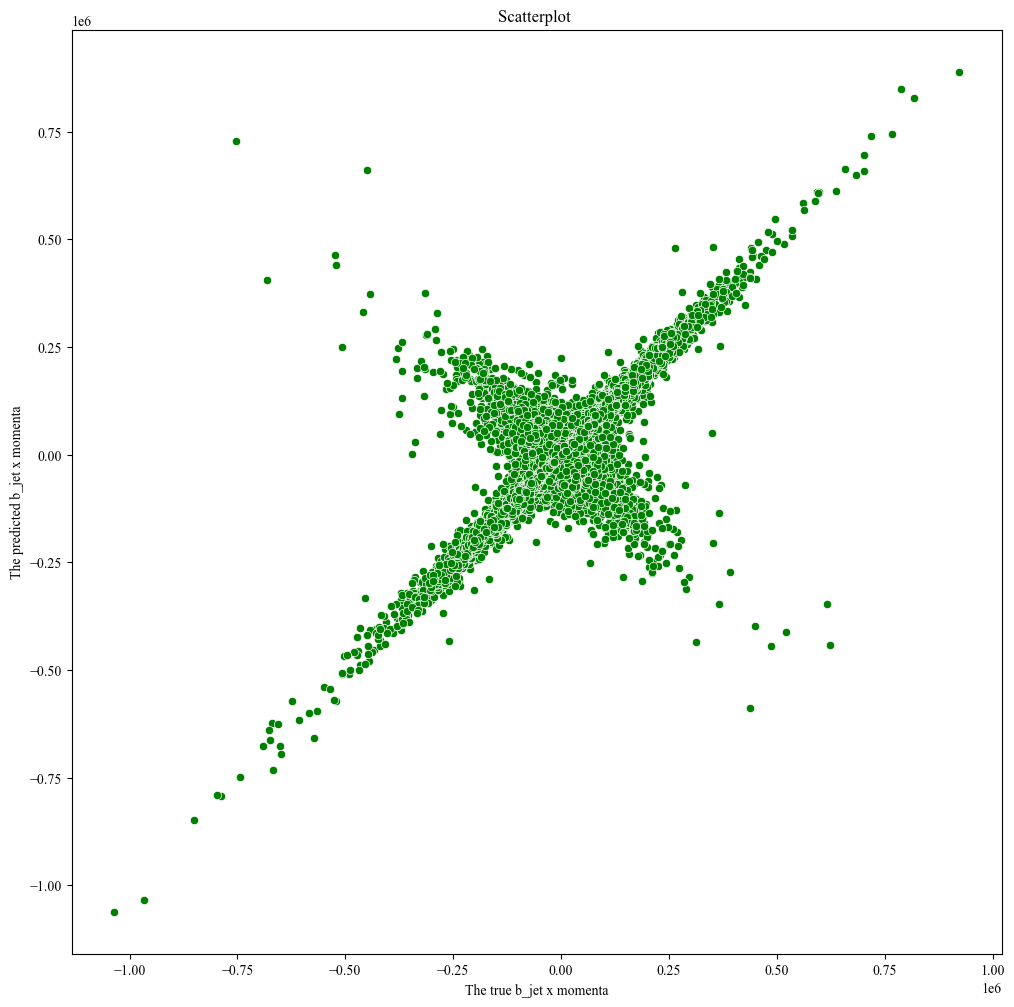

In [111]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = scaled_true_jets[:,0]*1e6,
    y = scaled_reconstructed_jets[:,0]*1e6,
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_ylabel("The predicted b_jet x momenta")
ax.set_xlabel("The true b_jet x momenta")
plt.show()